# Examining the Relationships Between Features and the Target

**Goals:** Get an idea of potential usefulness of each feature, do
feature engineering.

**Summary:** The primary purpose of this notebook is to identify steps 
that may improve performance of machine learning models. We summarize below 
our findings and the actions taken to achieve the stated goals.

1. **Determine potential usefulness of each numerical feature:** 
For each numerical feature, we determine if the difference between their 
mean values for the groups 'Charged Off' and 'Fully Paid' is statistically
significant. We do binning of each numerical feature, and take a look at 
the charge-off rate for each bin. The plotted charts indicate a roughly 
linear relationship between the charge-off rates and almost all features.
We calculate the Pearson and the Spearman correlation coefficients for 
each numerical feature against loan status to get a rough measure of
potential usefulness.


2. **Determine potential usefulness of each categorical feature:**
We determine the charge-off rate for each category of selected categorical 
features. The plotted charts indicate a roughly linear relationships between 
the charge-off rates and certain ordinalized features, but not others.  We 
calculate the Pearson and the Spearman correlation coefficients for the 
ordinalized features against loan status. The gathered data helps us 
determine the appropriate encoding (ordinal or one-hot) for the features.


3. **Do feature engineering:** The presence of features with tail-heavy 
histograms may make it hard for some machine learning algorithms to detect 
patterns. We apply *log10* transformation to such features, to make their 
distribution more bell-shaped. We engineer certain new features, and find 
that they perform better than some of the existing features

In [1]:
# Load required packages and modules.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil, floor, log
from scipy import stats
from matplotlib.ticker import PercentFormatter
from warnings import simplefilter

# Suppress performance warnings.
simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Create plots using seaborn's default aesthetic arguments.
sns.set()

# Make this notebook's output identical across runs.
np.random.seed(1)

In [2]:
# Read the training data into a pandas dataframe.
loan_data_train = pd.read_hdf('data/loan_data_train_and_test.hd5', 
                              key='train')

In [3]:
n_rows, n_cols = loan_data_train.shape
print(f'Size of the training dataset: {n_rows} rows and {n_cols} columns')

Size of the training dataset: 1076244 rows and 28 columns


Let's remind ourselves of the features:

In [4]:
print(sorted(loan_data_train.columns))

['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'fico_range_high', 'fico_range_low', 'home_ownership', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'tax_liens', 'term', 'total_acc', 'verification_status', 'zip_code']


Let's split the features into numerical features and categorical features:

In [5]:
# Numerical features
num_features = ['annual_inc', 'dti', 'fico_range_high', 'fico_range_low', 
                'installment', 'int_rate', 'loan_amnt', 'mort_acc', 
                'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 
                'revol_util', 'tax_liens', 'total_acc']

# Categorical features
cat_features = ['addr_state', 'application_type', 'earliest_cr_line', 
                'emp_length', 'home_ownership', 'initial_list_status', 
                'issue_d', 'purpose', 'sub_grade', 'term', 
                'verification_status', 'zip_code']

# Categorical features that have too many categories.
cat_features_too_many = ['earliest_cr_line', 'issue_d', 'zip_code']

# Categorical features that have a reasonable number of categories.
cat_features_reasonable = ['addr_state', 'application_type', 'emp_length', 
                           'home_ownership', 'initial_list_status', 
                           'purpose', 'sub_grade', 'term', 
                           'verification_status']

Let's create a copy of the training dataset, so that we can experiment with
it without affecting the original set:

In [6]:
loan_data = loan_data_train.copy()

## 1. Determine Potential Usefulness of Each Numerical Feature

Let's gather some statistics for each numerical feature grouped by loan 
status:

In [7]:
# Ensure that all columns are displayed.
pd.options.display.max_columns = None

# Round to two decimal places in pandas. 
pd.options.display.float_format = '{:.2f}'.format

(loan_data.groupby('loan_status')
          .describe(percentiles=[0.5])
          .stack(1)
          .unstack(0)
          .sort_index(axis='columns'))

annual_inc                     dti            fico_range_high  \
loan_status Charged Off  Fully Paid Charged Off Fully Paid     Charged Off   
count         214846.00   861398.00   214786.00  861163.00       214846.00   
mean           70483.12    77674.65       20.16      17.81          691.85   
std            63971.53    70318.92       11.43      10.98           25.95   
min                0.00        0.00        0.00       0.00          664.00   
50%            60000.00    65000.00       19.78      17.10          684.00   
max          9500000.00 10999200.00      999.00     999.00          850.00   

                       fico_range_low            installment             \
loan_status Fully Paid    Charged Off Fully Paid Charged Off Fully Paid   
count        861398.00      214846.00  861398.00   214846.00  861398.00   
mean            702.28         687.85     698.28      465.54     431.36   
std              32.83          25.95      32.83      262.81     260.82   
min             629.00         660.00     625.00       21.62      14.01   
50%             694.00         680.00     690.00      403.05     368.26   
max             850.00         845.00     845.00     1717.63    1719.83   

               int_rate              loan_amnt               mort_acc  \
loan_status Charged Off Fully Paid Charged Off Fully Paid Charged Off   
count         214846.00  861398.00   214846.00  861398.00   209358.00   
mean              15.71      12.62    15576.66   14134.49        1.37   
std                4.91       4.53     8811.02    8668.96        1.83   
min                5.31       5.31     1000.00     500.00        0.00   
50%               15.05      12.18    14400.00   12000.00        1.00   
max               30.99      30.99    40000.00   40000.00       29.00   

                          open_acc                pub_rec             \
loan_status Fully Paid Charged Off Fully Paid Charged Off Fully Paid   
count        829164.00   214846.00  861398.00   214846.00  861398.00   
mean              1.75       11.90      11.52        0.25       0.21   
std               2.04        5.64       5.43        0.64       0.58   
min               0.00        0.00       0.00        0.00       0.00   
50%               1.00       11.00      11.00        0.00       0.00   
max              51.00       76.00      90.00       61.00      49.00   

            pub_rec_bankruptcies              revol_bal             \
loan_status          Charged Off Fully Paid Charged Off Fully Paid   
count                  214755.00  860934.00   214846.00  861398.00   
mean                        0.15       0.13    15368.47   16479.86   
std                         0.40       0.37    19028.97   23110.83   
min                         0.00       0.00        0.00       0.00   
50%                         0.00       0.00    11079.00   11153.00   
max                        11.00      12.00  1746716.00 2904836.00   

             revol_util              tax_liens              total_acc  \
loan_status Charged Off Fully Paid Charged Off Fully Paid Charged Off   
count         214704.00  860856.00   214845.00  861365.00   214846.00   
mean              54.80      51.07        0.06       0.05       24.71   
std               23.85      24.61        0.42       0.37       12.11   
min                0.00       0.00        0.00       0.00        2.00   
50%               55.60      51.30        0.00       0.00       23.00   
max              182.80     193.00       61.00      46.00      176.00   

                        
loan_status Fully Paid  
count        861398.00  
mean             25.05  
std              11.97  
min               2.00  
50%              23.00  
max             162.00

Let's make box plots for each of the numerical features grouped by loan
status:

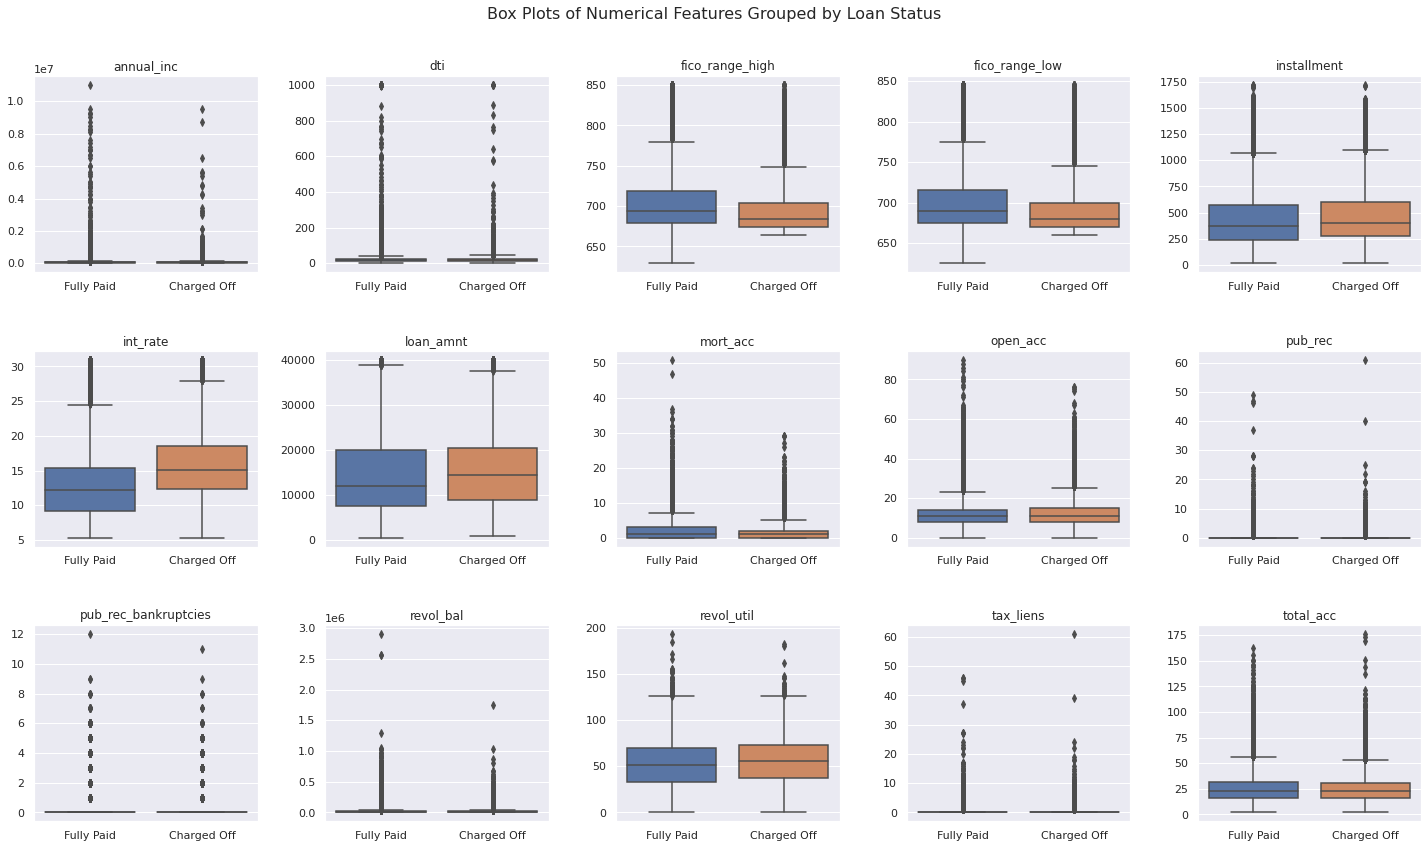

In [8]:
n_cols = 5
n_rows = ceil(len(num_features)/n_cols)
aspect = 1
fig = plt.figure(figsize=(20, (n_rows/n_cols)*(20/aspect)))
title = 'Box Plots of Numerical Features Grouped by Loan Status'
fig.suptitle(title, fontsize=16)

for counter, feature in enumerate(num_features, 1):
    ax = fig.add_subplot(n_rows, n_cols, counter)
    sns.boxplot(x='loan_status', y=feature, data=loan_data, ax=ax)
    ax.set_title(feature)
    ax.set_xlabel('')
    ax.set_ylabel('')       

fig.tight_layout()
fig.subplots_adjust(top=0.9, wspace=0.3, hspace=0.4)   

For each numerical feature, what's the difference between their mean values 
for the groups 'Charged Off' and 'Fully Paid'?

In [9]:
diff = (loan_data.groupby('loan_status')[num_features].mean()
                                        .sort_index(axis='columns'))
diff.loc['Difference %'] = ((diff.loc['Charged Off']-diff.loc['Fully Paid'])
                            /diff.loc['Fully Paid'])*100
diff

,annual_inc,dti,fico_range_high,fico_range_low,installment,int_rate,loan_amnt,mort_acc,open_acc,pub_rec,pub_rec_bankruptcies,revol_bal,revol_util,tax_liens,total_acc
loan_status,,,,,,,,,,,,,,,
Charged Off,70483.12,20.16,691.85,687.85,465.54,15.71,15576.66,1.37,11.90,0.25,0.15,15368.47,54.80,0.06,24.71
Fully Paid,77674.65,17.81,702.28,698.28,431.36,12.62,14134.49,1.75,11.52,0.21,0.13,16479.86,51.07,0.05,25.05
Difference %,-9.26,13.20,-1.48,-1.49,7.92,24.46,10.20,-21.55,3.36,18.75,18.10,-6.74,7.31,18.93,-1.34


Is the difference between the means statistically significant?
Our null hypothesis is that the two populations have equal means. 
We will use Welch's two-sided t-test, an adaptation of the more common 
Student's t-test. We use Welch's test because it is more reliable when 
the two samples have unequal variances and/or unequal sizes, as we have
in our case. While Welch's test does requires that the samples be normally 
distributed, which does not hold in our case, the sample sizes 
are large enough that non-normality is not a reason for concern. We carry out 
the test at the 1% significance level. Is any p-value greater than 1%?

In [10]:
# Masks to filter by 'Fully Paid' and 'Charged Off'.
mask_fully_paid = loan_data['loan_status'] == 'Fully Paid'
mask_charged_off = ~mask_fully_paid

[_, t_p_value] = stats.ttest_ind(loan_data[mask_fully_paid][num_features],
                                 loan_data[mask_charged_off][num_features],
                                 equal_var=False,
                                 nan_policy='omit')

print('Number of features with p-value greater than 1%:',
      (t_p_value > 0.01).sum())

Number of features with p-value greater than 1%: 0


We see that for every numerical feature, the difference between the means 
of the two populations ('Fully Paid' and 'Charged Off') is statistically 
significant at the 1% level.

Next, we wish to do decile binning for each numerical feature, and take a 
look at the charge-off rate for each bin. However, decile binning will fail 
for the features **mort_acc**, **pub_rec**, **pub_rec_bankruptcies**,
and **tax_liens** because of the nature of their distributions. For this
reason, will manually create custom bins for these features:

In [11]:
bin_edges = {
    'mort_acc': [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 51],
    'pub_rec': [-1, 0, 1, 2, 86],
    'pub_rec_bankruptcies': [-1, 0, 1, 12], 
    'tax_liens': [-1, 0, 1, 2, 85]              
}

Now that bin edges have been chosen for the problematic features, let's take 
a look at the charge-off rates for each bin:

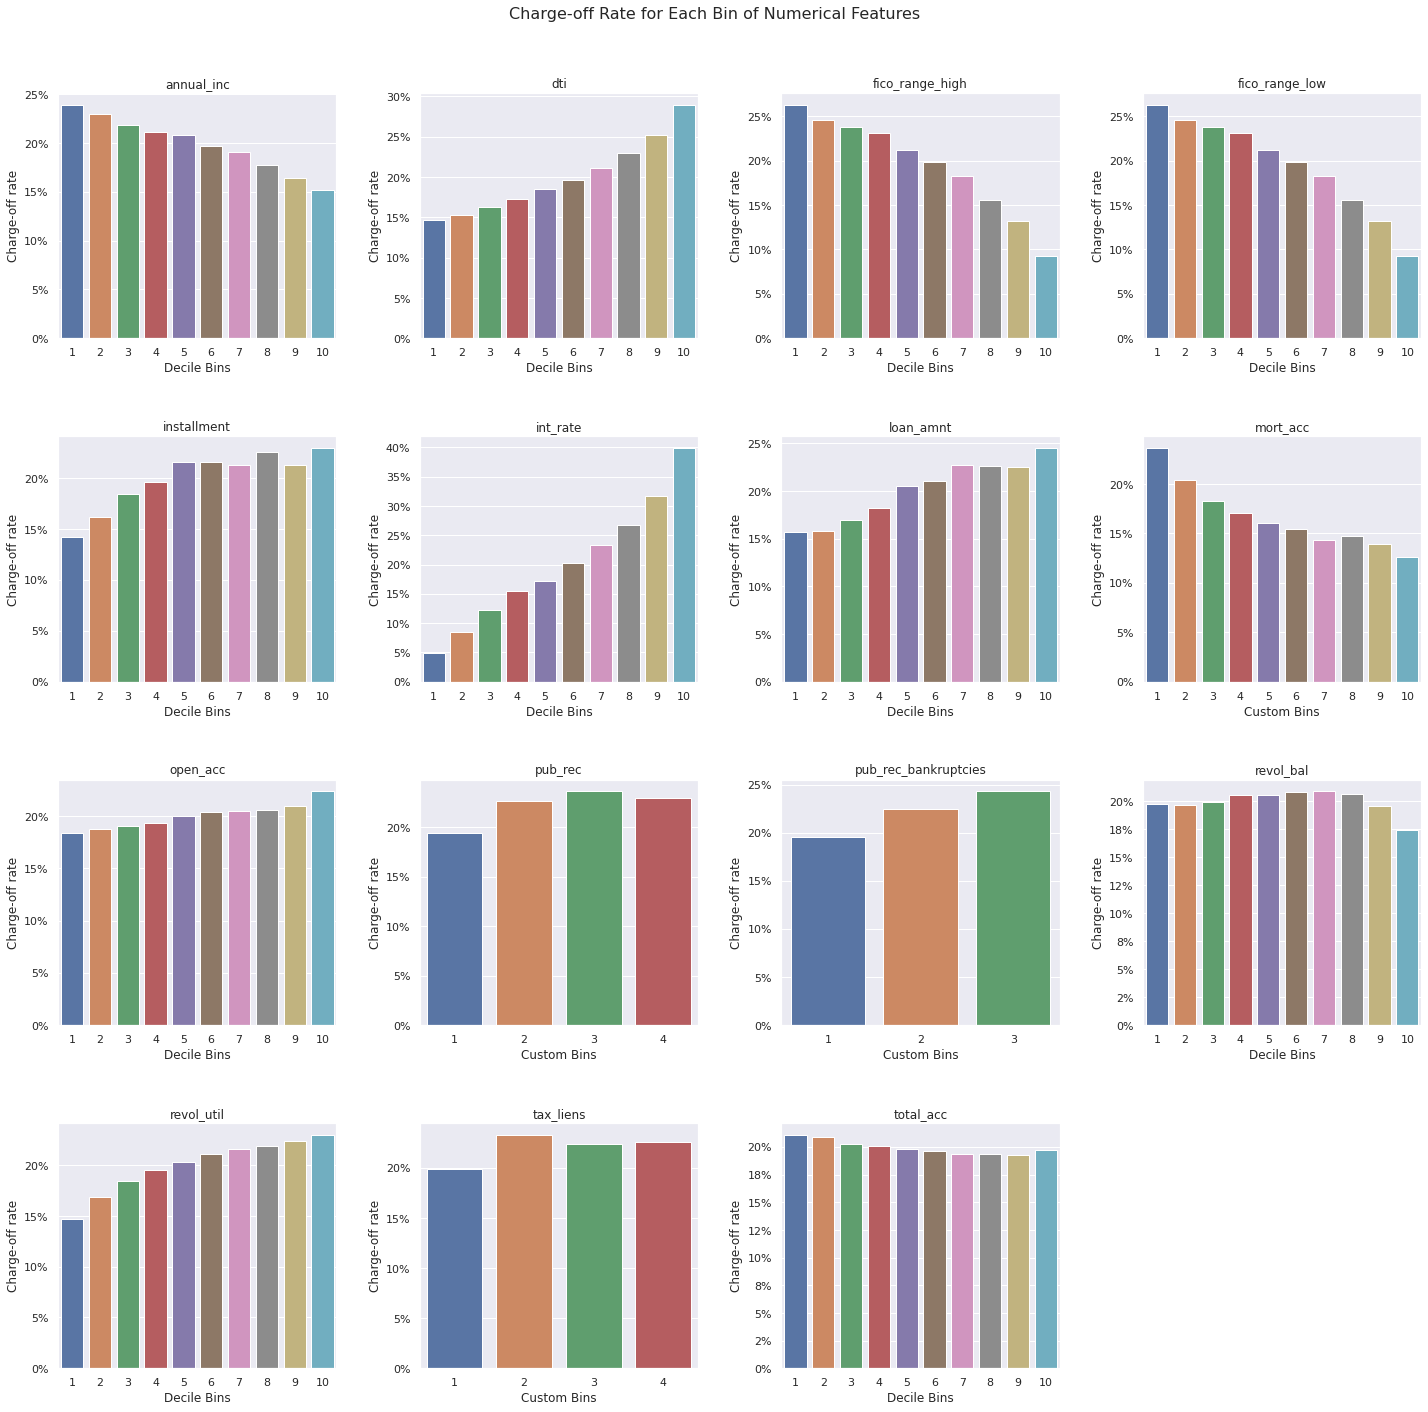

In [12]:
n_cols = 4
n_rows = ceil(len(num_features)/n_cols)
aspect = 1
fig = plt.figure(figsize=(20, (n_rows/n_cols)*(20/aspect)))
title = ('Charge-off Rate for Each Bin of Numerical Features')
fig.suptitle(title, fontsize=16)

for counter, feature in enumerate(num_features, 1):
    ax = fig.add_subplot(n_rows, n_cols, counter)
    if feature in bin_edges:
        bins = pd.cut(loan_data[feature], bins=bin_edges[feature])
        series = (loan_data.groupby(bins, observed=True)['loan_status']
                           .value_counts(normalize=True)
                           .loc[:, 'Charged Off'])    
        sns.barplot(x=series.index, y=series.tolist(), ax=ax)     
        ax.set_xlabel('Custom Bins')
        ax.set_xticklabels(np.arange(1, len(bin_edges[feature]), 1))
    else:
        bins = pd.qcut(loan_data[feature], q=10)
        series = (loan_data.groupby(bins, observed=True)['loan_status']
                           .value_counts(normalize=True)
                           .loc[:, 'Charged Off'])  
        sns.barplot(x=series.index, y=series.tolist(), ax=ax)     
        ax.set_xlabel('Decile Bins')
        ax.set_xticklabels(np.arange(1, 11, 1))    
    ax.set_title(feature)
    ax.set_ylabel('Charge-off rate')
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))     
fig.tight_layout()  
fig.subplots_adjust(top=0.92, wspace=0.3, hspace=0.4)

The charts above indicate a roughly linear relationship between the 
charge-off rates and almost all the features, particularly the
features **int_rate**, **fico_range_high**, **fico_range_low**,
**dti**, and **annual_inc**. As such, it appears that we do not need
to convert any numerical feature to a categorical feature. We will take
a look at the Pearson and the Spearman correlation coefficients for 
each numerical feature against loan status.


* Pearson's correlation coefficient measures the linear relationship 
between two variables, while Spearman's correlation coefficient measures 
the monotonicity of the relationship between two variables.


* Neither the Pearson correlation nor the Spearman correlation is 
strictly appropriate for categorical variables, as we have in our case 
(**loan_status**). Furthermore, the Pearson correlation requires that the 
samples be normally distributed, which does not hold in our case. 
Nevertheless, these correlation coefficients can still give us a quick 
idea of the potential usefulness of a feature.

First, we define a helper function and a function that calculates the two 
coefficients:

In [13]:
def sort_by_absolute_value(data, column):
    """Sort the rows of the given DataFrame by the absolute values of the
       given column.       
        
    Parameters
    ----------
    data : DataFrame, shape [n_samples, n_columns]
           Dataset.
    
    column : str
             Column name by which to sort.   
        
    Returns
    -------
    df : DataFrame
         The transformed DataFrame.
    """   
    # Sort by the absolute values of 'column'.
    new_index = data[column].abs().sort_values(ascending=False).index
    return data.reindex(new_index)    

In [14]:
def correlation(data, X, y, pearson=True, spearman=True):
    """Calculate the specified correlation coefficients for the given 
       variables against the given target variable.       
        
    Parameters
    ----------
    data : DataFrame, shape [n_samples, n_columns]
           Dataset.
    
    X : list
        Column names to consider.
        
    y : str
        Target column name.    
             
    pearson, spearman : boolean, optional, default True
        If true, calculate the Pearson and Spearman correlation coefficients
        for each column name in X against the target column name y, 
        respectively.
        
    Returns
    -------
    coeffs : list of DataFrames
             Pearson and Spearman correlation coefficients, sorted by their
             absolute values.
    """   
    from scipy.stats import pearsonr, spearmanr
    corr_funcs = {}
    if pearson: corr_funcs["Pearson's Coefficient"] = pearsonr
    if spearman: corr_funcs["Spearman's Coefficient"] = spearmanr
    
    coeffs = []
    for key in corr_funcs:
        tuples = []
        # Calculate the coefficients for each column name in X against the 
        # target column name y.
        for x in X:
            mask = data[x].notnull()
            tuples.append(corr_funcs[key](data[mask][x], data[mask][y]))
    
        # Gather the coefficients into a DataFrame.
        r_values, _ = zip(*tuples)
        df = pd.DataFrame({key: r_values}, index=X)
        df.index.name = 'Feature'

        # Sort by the absolute value of the coefficient.
        df = sort_by_absolute_value(df, key)
        coeffs.append(df)    
   
    return coeffs

Now, let's take a look at the Pearson and the Spearman correlation 
coefficients for each numerical feature against loan status, sorted by 
absolute value:

In [15]:
# Binarize the 'loan_status' feature.
loan_data['loan_status'].replace(
    ['Charged Off', 'Fully Paid'], [1, 0], inplace=True)
loan_data['loan_status'] = loan_data['loan_status'].astype(int)

# This function is due to Wes McKinney, author of the book
# 'Python for Data Analysis'.
def side_by_side(*objs, **kwds):
    ''' Print objects side-by-side '''
    from pandas.io.formats.printing import adjoin
    space = kwds.get('space', 4)
    reprs = [repr(obj).split('\n') for obj in objs]
    print(adjoin(space, *reprs))
    
# Print the Pearson and Spearman correlation coefficients for each numerical 
# feature against loan status, sorted by absolute value. 
corr_num_features = correlation(loan_data, num_features, 'loan_status')
side_by_side(*corr_num_features)

                      Pearson's Coefficient                          Spearman's Coefficient
Feature                                        Feature                                     
int_rate                               0.26    int_rate                                0.25
fico_range_low                        -0.13    fico_range_low                         -0.13
fico_range_high                       -0.13    fico_range_high                        -0.13
dti                                    0.08    dti                                     0.11
mort_acc                              -0.08    mort_acc                               -0.08
loan_amnt                              0.07    loan_amnt                               0.07
revol_util                             0.06    annual_inc                             -0.07
installment                            0.05    installment                             0.06
annual_inc                            -0.04    revol_util                       

We note that the top six features given by the Pearson and Spearman
correlation are identical.

## 2. Determine Potential Usefulness of Each Categorical Feature

Consider the categorical feature **application_type**, which has two
categories, 'Individual' and 'Joint App'. What is the probability that
a loan application of type 'Individual' is charged-off? What about
'Joint App'? Below, we answer this as well as analogous questions for other 
categorical features:

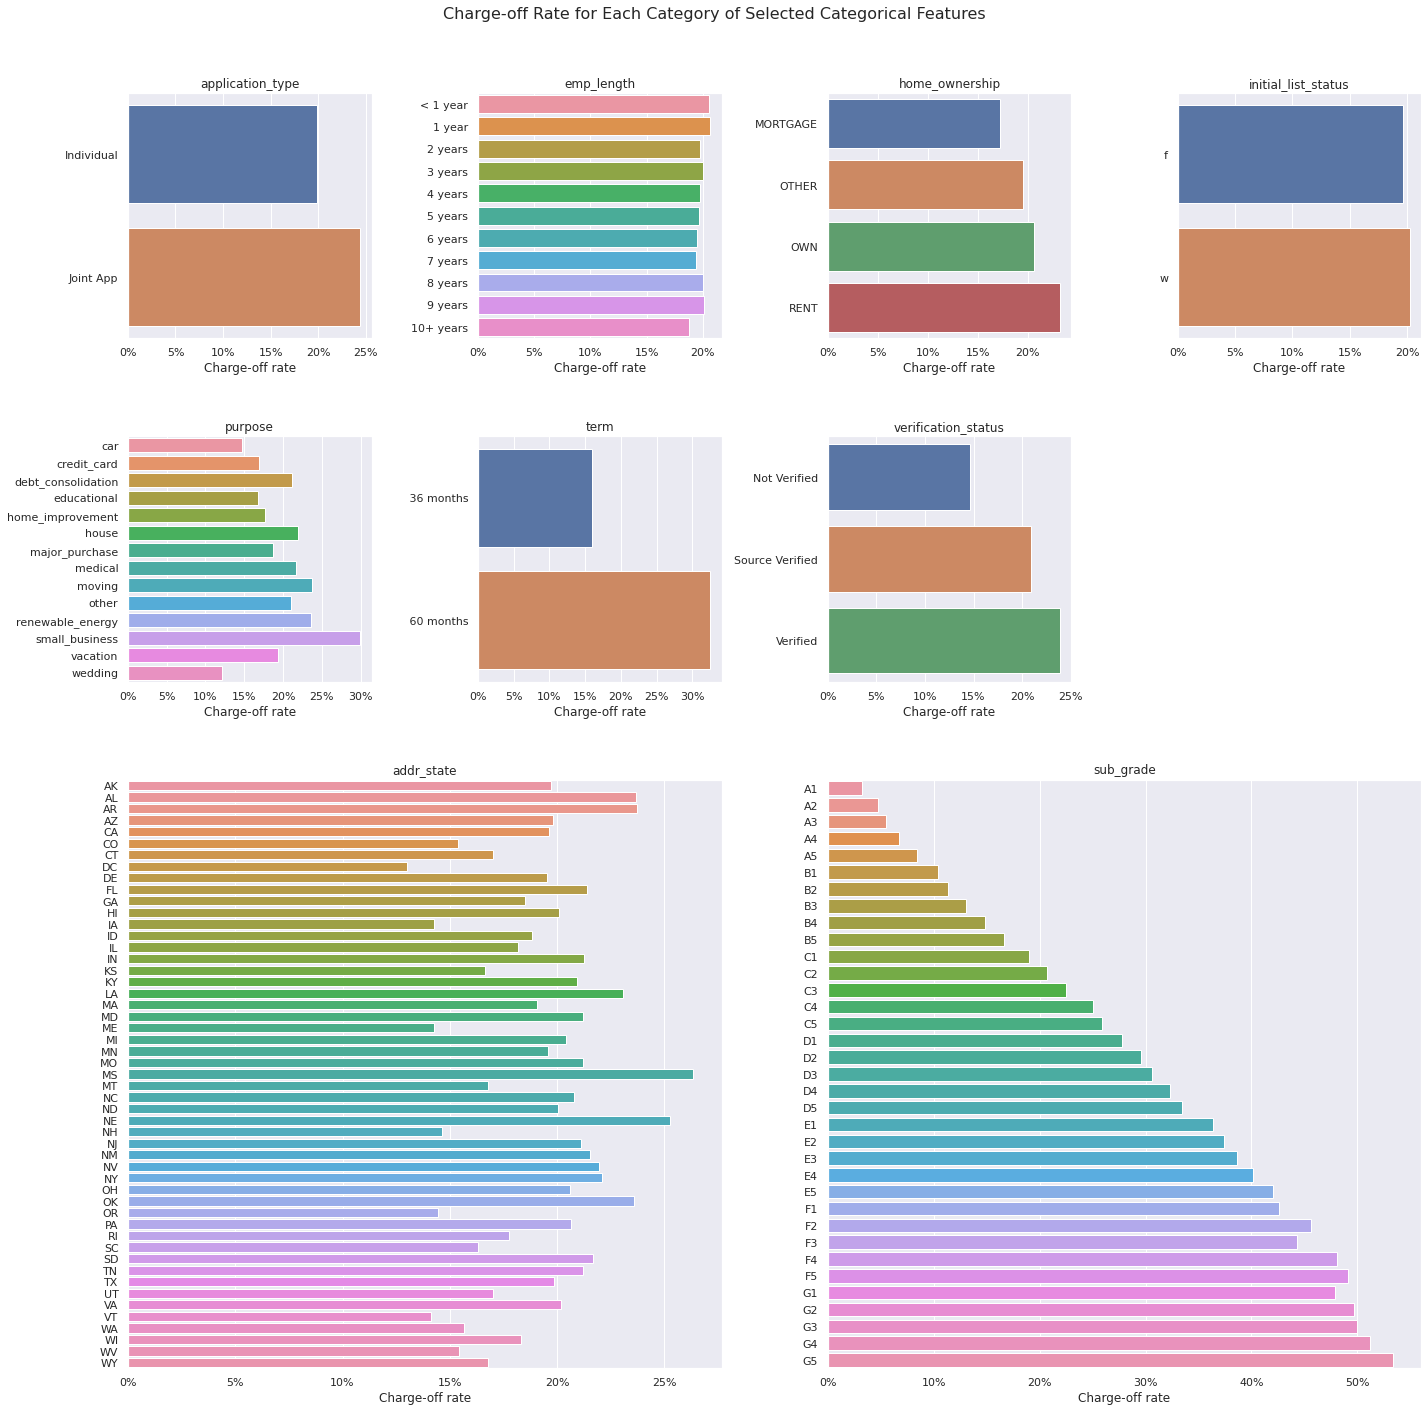

In [16]:
n_cols = 4
n_rows = 4
aspect = 1
fig = plt.figure(figsize=(20, (n_rows/n_cols)*(20/aspect)))
gs = fig.add_gridspec(n_rows, n_cols)
title = 'Charge-off Rate for Each Category of Selected Categorical Features'
fig.suptitle(title, fontsize=16)

# Move the features 'addr_state' and 'sub_grade' to the end of the list.
cat_features_tmp = [elm for elm in cat_features_reasonable
                    if elm not in ['addr_state', 'sub_grade']]
cat_features_tmp.extend(['addr_state', 'sub_grade'])

for counter, feature in enumerate(cat_features_tmp, 0):
    if feature == 'addr_state':
        ax = fig.add_subplot(gs[2:4, 0:2])
    elif feature == 'sub_grade':
        ax = fig.add_subplot(gs[2:4, 2:4])
    else:
        ax = fig.add_subplot(gs[counter // n_cols, counter % n_cols])
    series = (loan_data.groupby(feature)['loan_status'] 
                       .value_counts(normalize=True) 
                       .loc[:, 1])
    if feature == 'emp_length':
        order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', 
                 '5 years', '6 years', '7 years', '8 years', '9 years',  
                 '10+ years']
    else:
        order = sorted(loan_data[feature].unique())
    sns.barplot(x=series.tolist(), y=series.index, order=order, ax=ax)     
    ax.set_title(feature)
    ax.set_xlabel('Charge-off rate')
    ax.set_ylabel('')
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))  

fig.tight_layout()  
fig.subplots_adjust(top=0.92, hspace=0.4)

The charts above indicate a roughly linear relationship between the 
charge-off rates and the ordinalized features **term** and **sub_grade**. 
Let's take a look at the Pearson and the Spearman correlation coefficients 
for these ordinalized features against loan status. Our earlier caveats about 
using the Pearson and Spearman correlations apply here too. 

In [17]:
# Ordinalize the feature 'term'.
loan_data['term'].replace([' 36 months', ' 60 months'], [0, 1], inplace=True)
loan_data['term'] = loan_data['term'].astype(int)

# Categories for the feature 'sub_grade'.
sub_grade_cats = ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 
                  'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 
                  'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 
                  'G1', 'G2', 'G3', 'G4', 'G5']

# Ordinalize the features 'sub_grade'.
loan_data['sub_grade'].replace(sub_grade_cats, np.arange(0, 35, 1), 
                               inplace=True)
loan_data['sub_grade'] = loan_data['sub_grade'].astype(int)

# Print the Pearson and Spearman correlation coefficients for the features
# 'term' and 'sub_grade' against 'loan_status', sorted by absolute value. 
corr_ord_features = correlation(loan_data, ['term', 'sub_grade'], 
                                'loan_status')
side_by_side(*corr_ord_features)

           Pearson's Coefficient               Spearman's Coefficient
Feature                             Feature                          
sub_grade                   0.27    sub_grade                    0.26
term                        0.18    term                         0.18


* In the notebook *Exploring and Cleaning the Data* we stated that we would 
consider ordinal encoding for the features **emp_length**, **sub_grade**, 
and **term**. The charts above indicate a roughly linear relationship between 
charge-off rates and the ordinalized features **sub_grade** and **term**, and 
that this is not the case for the ordinalized feature **emp_length**. 


* Since some linear machine learning algorithms work best if the 
relationship between the rates of the positive class and the features 
are linear, it is not appropriate to use ordinal encoding for the 
feature **emp_length**. As such, we will use one-hot encoding for 
the feature **emp_length**, and we will use ordinal encoding for the 
feature **sub_grade**. As for the feature **term**, ordinal encoding is 
appropriate, but since there are only two categories we will go with 
one-hot encoding.

## 3. Do Feature Engineering

The features **annual_inc**, **dti**, and **revol_bal** have tail-heavy 
histograms, as noted in the notebook *Exploring and Cleaning the Data*. 
Since this may make it hard for some machine learning algorithms to 
detect patterns, we apply *log10* transformation to make their 
distribution more bell-shaped:

In [18]:
loan_data['annual_inc_log'] = np.log10(loan_data['annual_inc'] + 1)
loan_data['dti_log'] = np.log10(loan_data['dti'] + 1)
loan_data['revol_bal_log'] = np.log10(loan_data['revol_bal'] + 1)

Let's take a look at the histogram of each log-transformed feature:

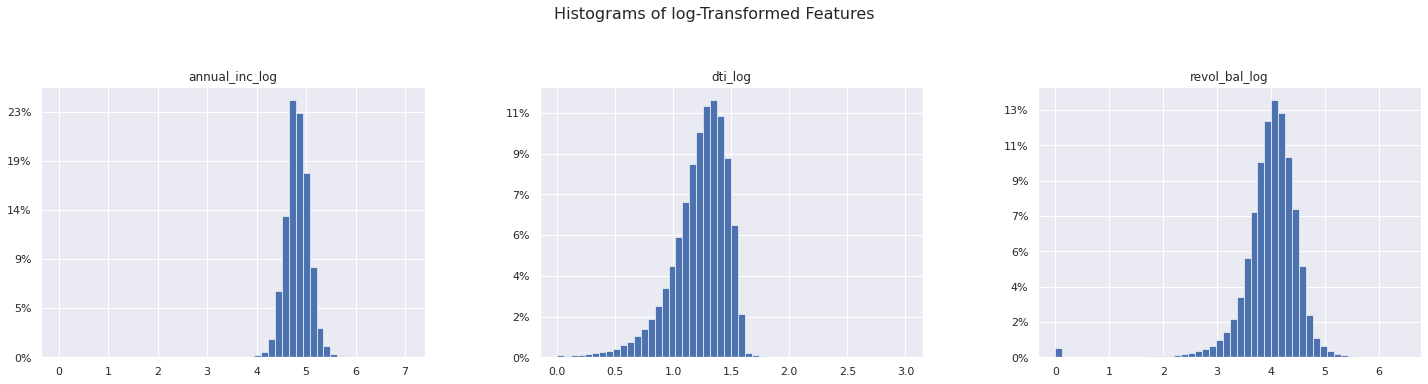

In [19]:
n_cols = 3
n_rows = ceil(len(num_features)/n_cols)
aspect = 1.5
fig = plt.figure(figsize=(20, (n_rows/n_cols)*(20/aspect)))
fig.suptitle('Histograms of log-Transformed Features', fontsize=16)
log_features = ['annual_inc_log', 'dti_log', 'revol_bal_log']

for counter, feature in enumerate(log_features, 1):
    ax = fig.add_subplot(n_rows, n_cols, counter)
    sns.histplot(bins=50, x=feature, data=loan_data, stat='count', 
                 alpha=1, ax=ax)
    ax.set_title(feature)  
    ax.set_xlabel('')
    ax.set_ylabel('')  
    xmax = loan_data[feature].notnull().sum()
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=xmax, decimals=0))

fig.tight_layout()
fig.subplots_adjust(top=0.93, wspace=0.3)  

How are the features **fico_range_high** and **fico_range_low** related?

In [20]:
print((loan_data['fico_range_high'] - loan_data['fico_range_low']).unique())

[4. 5.]


We see that there is no point in keeping both the features 
**fico_range_high** and **fico_range_low**. Let's add the average of these
features as a new feature:

In [21]:
loan_data['fico_score_avg'] = (0.5*loan_data['fico_range_high'] 
                               + 0.5*loan_data['fico_range_low'])

There are three features we haven't addressed yet: **earliest_cr_line'**, 
**'issue_d'**, and **'zip_code'**. In the notebook *Exploring and Cleaning 
the Data* we stated that we would consider:
* combining the features **earliest_cr_line'** and **'issue_d'** to 
approximate the age of the borrower's oldest credit account, and

* creating a new feature containing the median income of each 3-digit 
zip code.

Let's get to that now.

In [22]:
start_date = pd.to_datetime(loan_data['earliest_cr_line'], format='%b-%Y') 
end_date = pd.to_datetime(loan_data['issue_d'], format='%b-%Y')
# Compute the approximate age of the oldest credit line.                        
cr_line_age = (end_date - start_date).dt.days

Let's add the approximate age of the oldest credit line as a new feature:

In [23]:
loan_data['cr_line_age'] = cr_line_age

We will now add a new feature containing the median income of each 3-digit 
zip code, based on the
[data](https://www.psc.isr.umich.edu/dis/census/Features/tract2zip/) 
gathered from the *Population Studies Center*, at the University of Michigan.

In [24]:
# Read the zip code data into a pandas dataframe.
zip_code_data = pd.read_excel(
    'data/median_household_income_by_zip_code_2006-2010.xlsx', 
    usecols=[0,1, 2])

Let's take a look at first five rows of the zip code dataset, chosen randomly:

In [25]:
zip_code_data.sample(5)

,zip,median_income,pop
27903,81650,68158.22,12947
5368,17945,49283.98,158
28149,83325,39563.00,918
5792,19127,55768.88,5462
31571,97345,48841.11,512


In [26]:
zip_code_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32634 entries, 0 to 32633
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   zip            32634 non-null  int64  
 1   median_income  32634 non-null  float64
 2   pop            32634 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 765.0 KB


We see that there are 32634 zip codes. Our loan data contains only the first
three-digits of the zip code, so let's group the zip code data by
the first three digits, and then compute the median income:

In [27]:
# Create a column containing the first three digits of each zip code
zip_code_data['zip3'] = zip_code_data['zip'].apply(lambda x: str(x)[:3]+'xx')

# Group by the first three-digits of the zip code, and compute the average
# of the median incomes weighed by population, to get a series
get_wavg = lambda g: np.average(g['median_income'], weights=g['pop'])
zip3_code_data = zip_code_data.groupby('zip3').apply(get_wavg)

Let's take a look at first five rows of the new zip code dataset, 
chosen randomly:

In [28]:
zip3_code_data.sample(5)

zip3
894xx   56923.32
255xx   45706.45
781xx   59832.77
503xx   54772.18
274xx   47990.69
dtype: float64

How many unique 3-digit zip codes are there in our zip code dataset? 
How many in our training set?

In [29]:
print('Number of 3-digit zip codes in the zip code dataset:', 
      len(zip3_code_data))
print('Number of 3-digit zip codes in the training dataset:', 
      loan_data['zip_code'].nunique())

Number of 3-digit zip codes in the zip code dataset: 841
Number of 3-digit zip codes in the training dataset: 937


We see that some zip codes are missing from our zip code dataset. Let's
add in the missing data. There may be some zip codes from the test set that 
are also missing; we will account for these too.

In [30]:
# Read the test data into a pandas dataframe.
loan_data_test = pd.read_hdf('data/loan_data_train_and_test.hd5', 
                              key='test')
missing_zip_codes = (
    (set(loan_data['zip_code'])
     .union(set(loan_data_test['zip_code']))) 
     - set(zip3_code_data.index))
mean = zip3_code_data.mean()
zip3_code_data = zip3_code_data.append(
    pd.Series(mean, index=missing_zip_codes))

We saw in the notebook *Exploring and Cleaning the Data* that the feature
**zip_code** has one missing value, and that the most frequent value is
'945xx'. Let's fill in the missing value with most frequent value, and
then add the median zip code income as a new feature:

In [31]:
loan_data['zip_code'].fillna('945xx', inplace=True)
zip_code_inc = zip3_code_data[loan_data['zip_code']].values
loan_data['zip_code_inc'] = zip_code_inc

Let's save the zip code income data for later use:

In [32]:
zip3_code_data.to_hdf('data/loan_data_train_and_test.hd5', 
                      key='zip_code', mode='a')

Let's do binning of each new feature, and take a look at the charge-off rate 
for each bin:

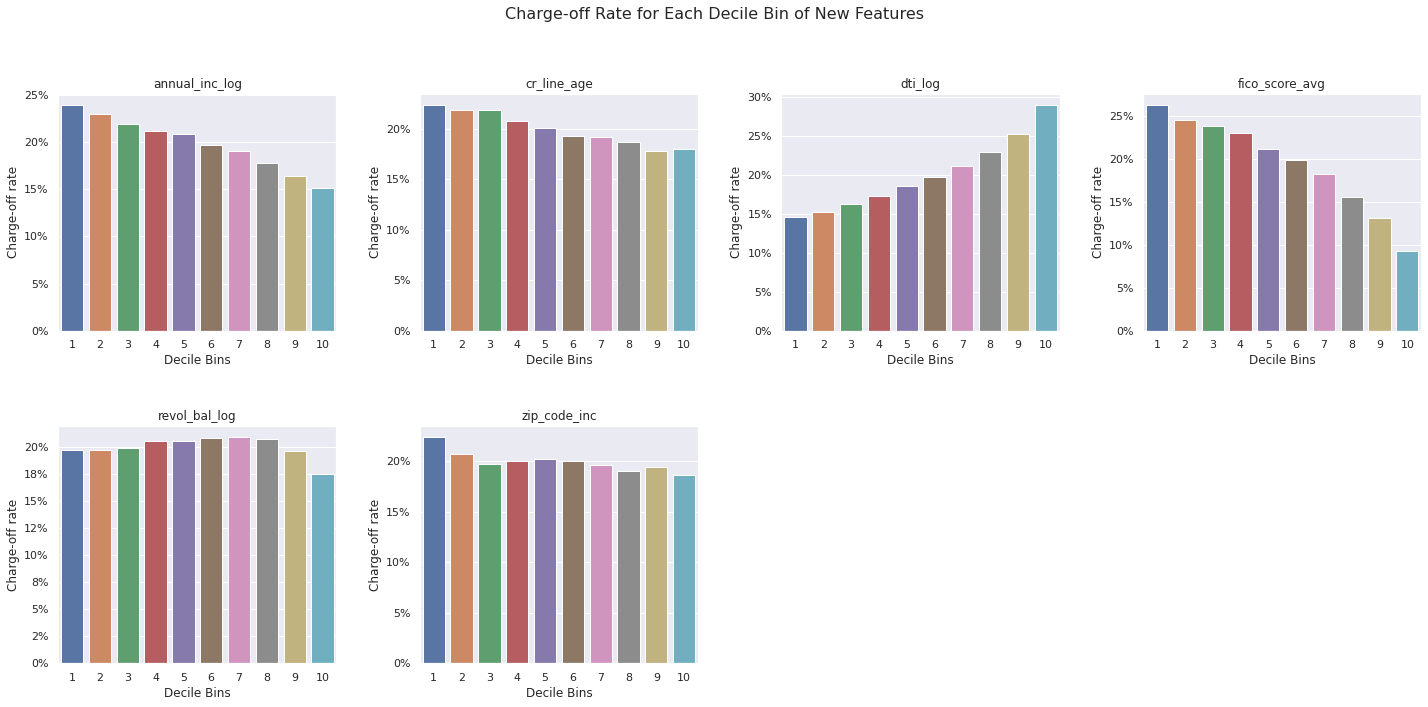

In [33]:
new_features = ['annual_inc_log', 'cr_line_age', 'dti_log', 'fico_score_avg',
                'revol_bal_log', 'zip_code_inc']
n_cols = 4
n_rows = ceil(len(new_features)/n_cols)
aspect = 1
fig = plt.figure(figsize=(20, (n_rows/n_cols)*(20/aspect)))
title = ('Charge-off Rate for Each Decile Bin of New Features')
fig.suptitle(title, fontsize=16)

for counter, feature in enumerate(new_features, 1):
    bins = pd.qcut(loan_data[feature], q=10)
    series = (loan_data.groupby(bins, observed=True)['loan_status']
                       .value_counts(normalize=True)
                       .loc[:, 1])
    ax = fig.add_subplot(n_rows, n_cols, counter)
    sns.barplot(x=series.index, y=series.tolist(), ax=ax)     
    ax.set_title(feature)
    ax.set_xlabel('Decile Bins')
    ax.set_ylabel('Charge-off rate')
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0)) 
    ax.set_xticklabels(np.arange(1, 11, 1))
fig.tight_layout()  
fig.subplots_adjust(top=0.86, wspace=0.3, hspace=0.4)

Let's take a look at the Pearson and the Spearman correlation coefficients 
for each of the new features against loan status, sorted by absolute value:

In [34]:
corr_new_features = correlation(loan_data, new_features, 'loan_status')
side_by_side(*corr_new_features)

                Pearson's Coefficient                    Spearman's Coefficient
Feature                                  Feature                               
fico_score_avg                  -0.13    fico_score_avg                   -0.13
dti_log                          0.09    dti_log                           0.11
annual_inc_log                  -0.06    annual_inc_log                   -0.07
cr_line_age                     -0.03    cr_line_age                      -0.04
zip_code_inc                    -0.02    zip_code_inc                     -0.02
revol_bal_log                   -0.01    revol_bal_log                    -0.01


We observe that some of our new features perform better than some of the 
existing features, and that some of our log-transformed features show
an improvement over the original versions. We also note that applying a 
monotonous transformation such as *log10* has no effect on the Spearman 
coefficient. 

Let's take a look at the final ranking of the features, including the new
features, as determined by the absolute values of the Pearson and Spearman 
correlation coefficients:

In [35]:
zipped = list(zip(corr_num_features, corr_ord_features, corr_new_features))
corr_dfs = {"Pearson's Coefficient": pd.concat(zipped[0]),
            "Spearman's Coefficient": pd.concat(zipped[1])}
rows_to_drop = ['annual_inc', 'dti', 'fico_range_high', 'fico_range_low', 
                'revol_bal']
for key in corr_dfs:
    corr_dfs[key].drop(index=rows_to_drop, inplace=True) 
    corr_dfs[key] = sort_by_absolute_value(corr_dfs[key], key)
side_by_side(*corr_dfs.values())

                      Pearson's Coefficient                          Spearman's Coefficient
Feature                                        Feature                                     
sub_grade                              0.27    sub_grade                               0.26
int_rate                               0.26    int_rate                                0.25
term                                   0.18    term                                    0.18
fico_score_avg                        -0.13    fico_score_avg                         -0.13
dti_log                                0.09    dti_log                                 0.11
mort_acc                              -0.08    mort_acc                               -0.08
loan_amnt                              0.07    loan_amnt                               0.07
annual_inc_log                        -0.06    annual_inc_log                         -0.07
revol_util                             0.06    installment                      

Instead of saving our engineered features, we will perform automated feature 
engineering in the next notebook.